In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,learning_curve, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
import shap
from scipy.special import expit

In [2]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\vodka.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
x = df.drop(columns=['quality'])
y = df['quality']

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.35, random_state=42)

In [5]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

In [7]:
param_grid = {
    'rf__n_estimators': [50, 100, 300],
    'rf__max_features' : ['sqrt','log2'],
    'rf__max_depth' : [5, 12, 20],
    'rf__min_samples_leaf' : [1,3,5],
    'rf__min_samples_split' : [2,5,8],
    'rf__bootstrap' : [True, False],
    'rf__criterion' : ['squared_error','friedman_mse','poisson','absolute_error']
}

grid_search = GridSearchCV(pipeline,
param_grid=param_grid,
scoring='neg_mean_squared_error',
cv=5,
n_jobs=-1,
verbose = 1,
)

grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
{'rf__bootstrap': False, 'rf__criterion': 'poisson', 'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}


In [ ]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)
print(y_pred)

In [ ]:
proba = expit(y_pred)
print(proba)

In [ ]:
prediksi = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\vodkapredict.csv")
prediksi.head()

In [ ]:
y_prediksi = best_model.predict(prediksi)
probabilitas_prediksi = expit(y_prediksi)
print(y_prediksi)
print(probabilitas_prediksi)

In [9]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)

n = len(y_test)
p = x_test.shape[1]
r2_adj = 1 - ((1-r2) * (n - 1) / (n - p - 1))

print(mse)
print(mae)
print(rmse)
print(r2)
print(r2_adj)

0.3577032685086212
0.44376118835398015
0.5980829946659755
0.45295068174399367
0.4419697647717016


In [12]:
cv_scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [-0.33051858 -0.42519446 -0.36235608 -0.36670214 -0.29888081]
Mean CV Accuracy: -0.35673041381974757


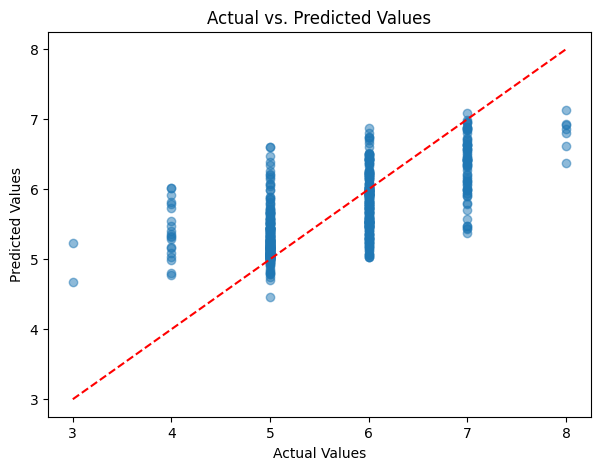

In [13]:
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') 
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

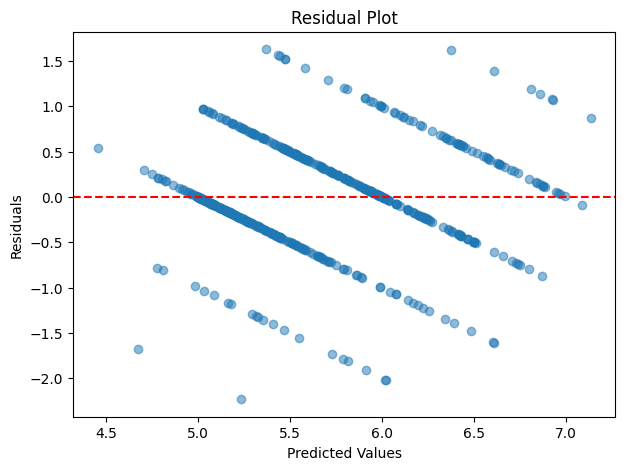

In [14]:
residuals = y_test - y_pred

plt.figure(figsize=(7, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

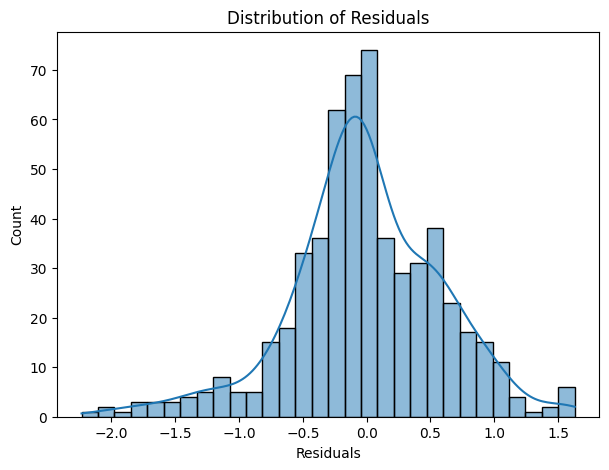

In [15]:
plt.figure(figsize=(7, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()

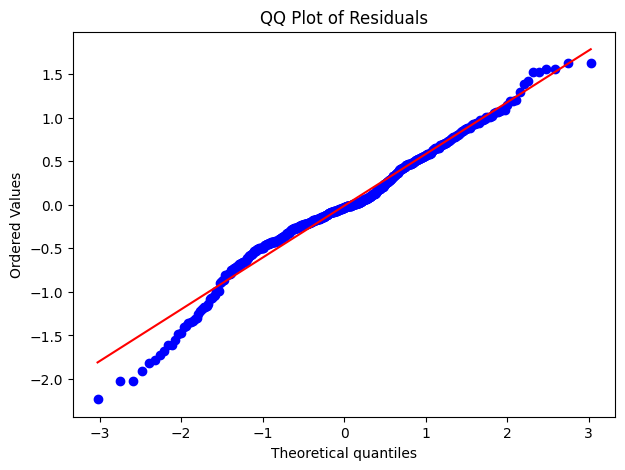

In [16]:
plt.figure(figsize=(7, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

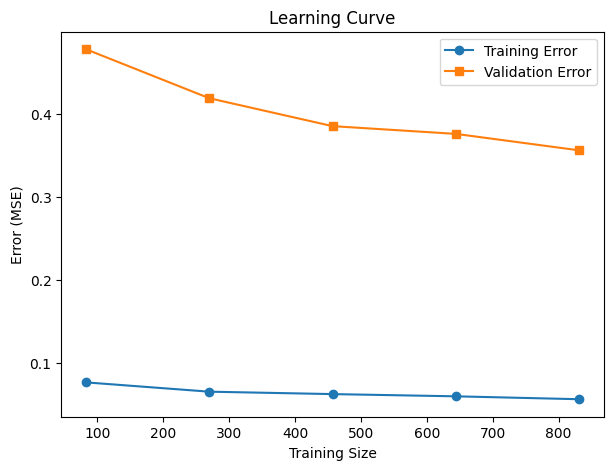

In [17]:
train_sizes, train_scores, test_scores = learning_curve(best_model, x_train, y_train, cv=5, scoring="neg_mean_squared_error")

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(7, 5))
plt.plot(train_sizes, train_mean, label="Training Error", marker="o")
plt.plot(train_sizes, test_mean, label="Validation Error", marker="s")
plt.xlabel("Training Size")
plt.ylabel("Error (MSE)")
plt.legend()
plt.title("Learning Curve")
plt.show()

In [18]:
rf = best_model.named_steps['rf']
feature_importances = pd.DataFrame({
    'Feature': x.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending =False)

print(feature_importances)

                 Feature  Importance
10               alcohol    0.244861
9              sulphates    0.151563
1       volatile acidity    0.126503
7                density    0.086760
6   total sulfur dioxide    0.073334
2            citric acid    0.065660
4              chlorides    0.057181
0          fixed acidity    0.052184
8                     pH    0.051902
5    free sulfur dioxide    0.045255
3         residual sugar    0.044797


C:\Users\Robyi\AppData\Local\Temp\ipykernel_4856\3486866868.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'], orient="h", palette="viridis")


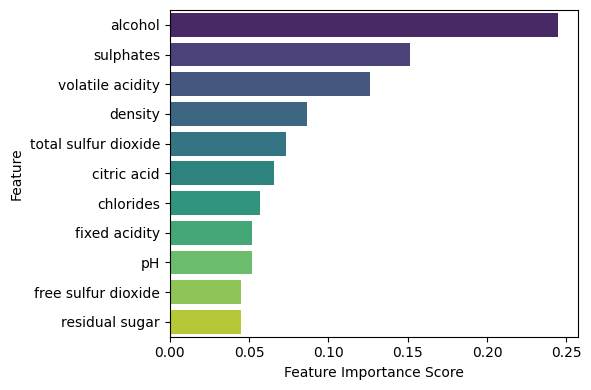

In [19]:
plt.figure(figsize=(6, 4))
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'], orient="h", palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()

In [20]:
explainer = shap.Explainer(rf, x_train)
shap_values = explainer(x_test)

 95%|=================== | 533/560 [00:16<00:00]       

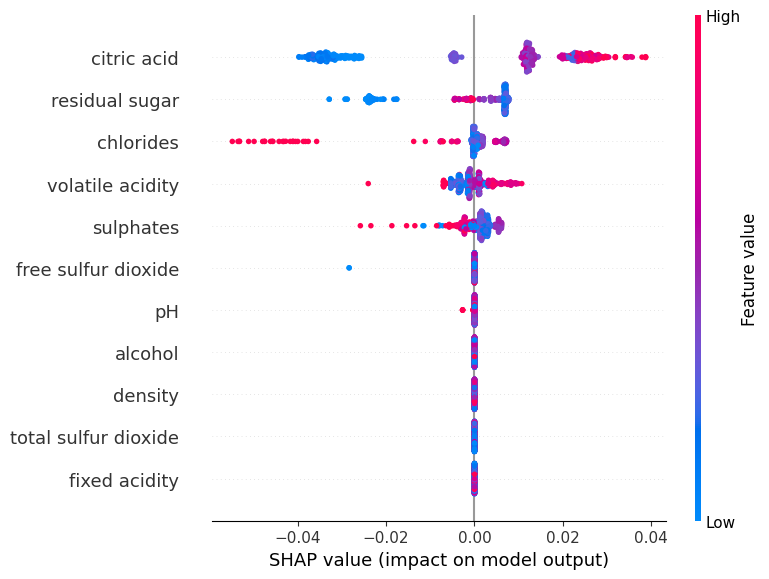

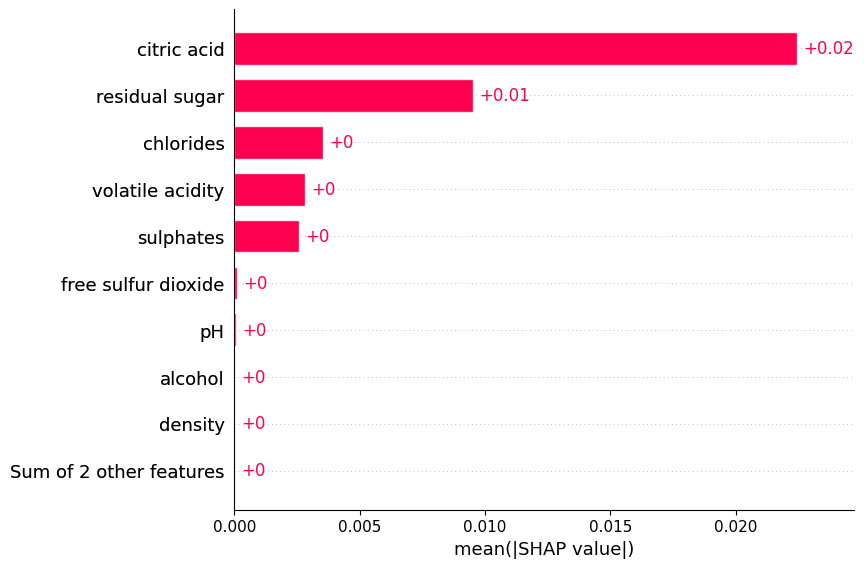

In [21]:
shap.summary_plot(shap_values, x_test, feature_names=x.columns)
shap.plots.bar(shap_values)